# Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader


import numpy as np
import pandas as pd

from utils import print_tensor_like_image

# 1. Data Loading and Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize data
])

# Download and load the training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Define the size of the validation set
val_size = 10000
train_size = len(trainset) - val_size

# Split the dataset into training and validation sets
trainset, valset = random_split(trainset, [train_size, val_size])

# Create DataLoaders for training and validation sets
trainloader = DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=512, shuffle=False, num_workers=2)


# Download and load test data # NOTE : No need to shuffle
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)


# Example: printing the number of batches in each loader
print(f'Number of points in trainset: {len(trainset)}')
print(f'Number of points in valset: {len(valset)}')
print(f'Number of points in testset: {len(testset)}')


/home/aditya/miniconda3/envs/QCNet/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/aditya/miniconda3/envs/QCNet/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Number of points in trainset: 50000
Number of points in valset: 10000
Number of points in testset: 10000


__________________________________
# 4. MODEL ARCHITECTURE & FORWARD PASS
________________________

In [2]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, out_dim)
        self.relu = nn.ReLU()  

    def forward(self, x):
        x = x.view(-1, 28*28)
        
        h1 = self.relu(self.fc1(x))  
        h2 = self.relu(self.fc2(h1))  
        h3 = self.fc3(h2)
        
        return h3


In [3]:
### 4.1 Train Model

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Initialize the model, loss function, and optimizer
model = Net(in_dim=28*28, out_dim=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.0005)

# Parameters for early stopping
patience = 5
delta = 0.01
best_val_loss = np.inf
patience_counter = 0
train_losses , val_losses = [], []

# Training loop with early stopping
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in trainloader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(trainset)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in valloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss = val_loss / len(valset)
    
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
        
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

print("Training complete")


Epoch 1/100 - Train Loss: 1.1040 - Val Loss: 0.4728
Epoch 2/100 - Train Loss: 0.3909 - Val Loss: 0.3395
Epoch 3/100 - Train Loss: 0.3133 - Val Loss: 0.2963
Epoch 4/100 - Train Loss: 0.2756 - Val Loss: 0.2670
Epoch 5/100 - Train Loss: 0.2495 - Val Loss: 0.2423
Epoch 6/100 - Train Loss: 0.2249 - Val Loss: 0.2221
Epoch 7/100 - Train Loss: 0.2060 - Val Loss: 0.2094
Epoch 8/100 - Train Loss: 0.1913 - Val Loss: 0.1977
Epoch 9/100 - Train Loss: 0.1775 - Val Loss: 0.1875
Epoch 10/100 - Train Loss: 0.1639 - Val Loss: 0.1802
Epoch 11/100 - Train Loss: 0.1537 - Val Loss: 0.1659
Epoch 12/100 - Train Loss: 0.1433 - Val Loss: 0.1640
Epoch 13/100 - Train Loss: 0.1341 - Val Loss: 0.1566
Epoch 14/100 - Train Loss: 0.1269 - Val Loss: 0.1527
Epoch 15/100 - Train Loss: 0.1177 - Val Loss: 0.1418
Epoch 16/100 - Train Loss: 0.1112 - Val Loss: 0.1437
Epoch 17/100 - Train Loss: 0.1047 - Val Loss: 0.1329
Epoch 18/100 - Train Loss: 0.0988 - Val Loss: 0.1301
Epoch 19/100 - Train Loss: 0.0932 - Val Loss: 0.1276
Ep

### 4.2 Visualise Results

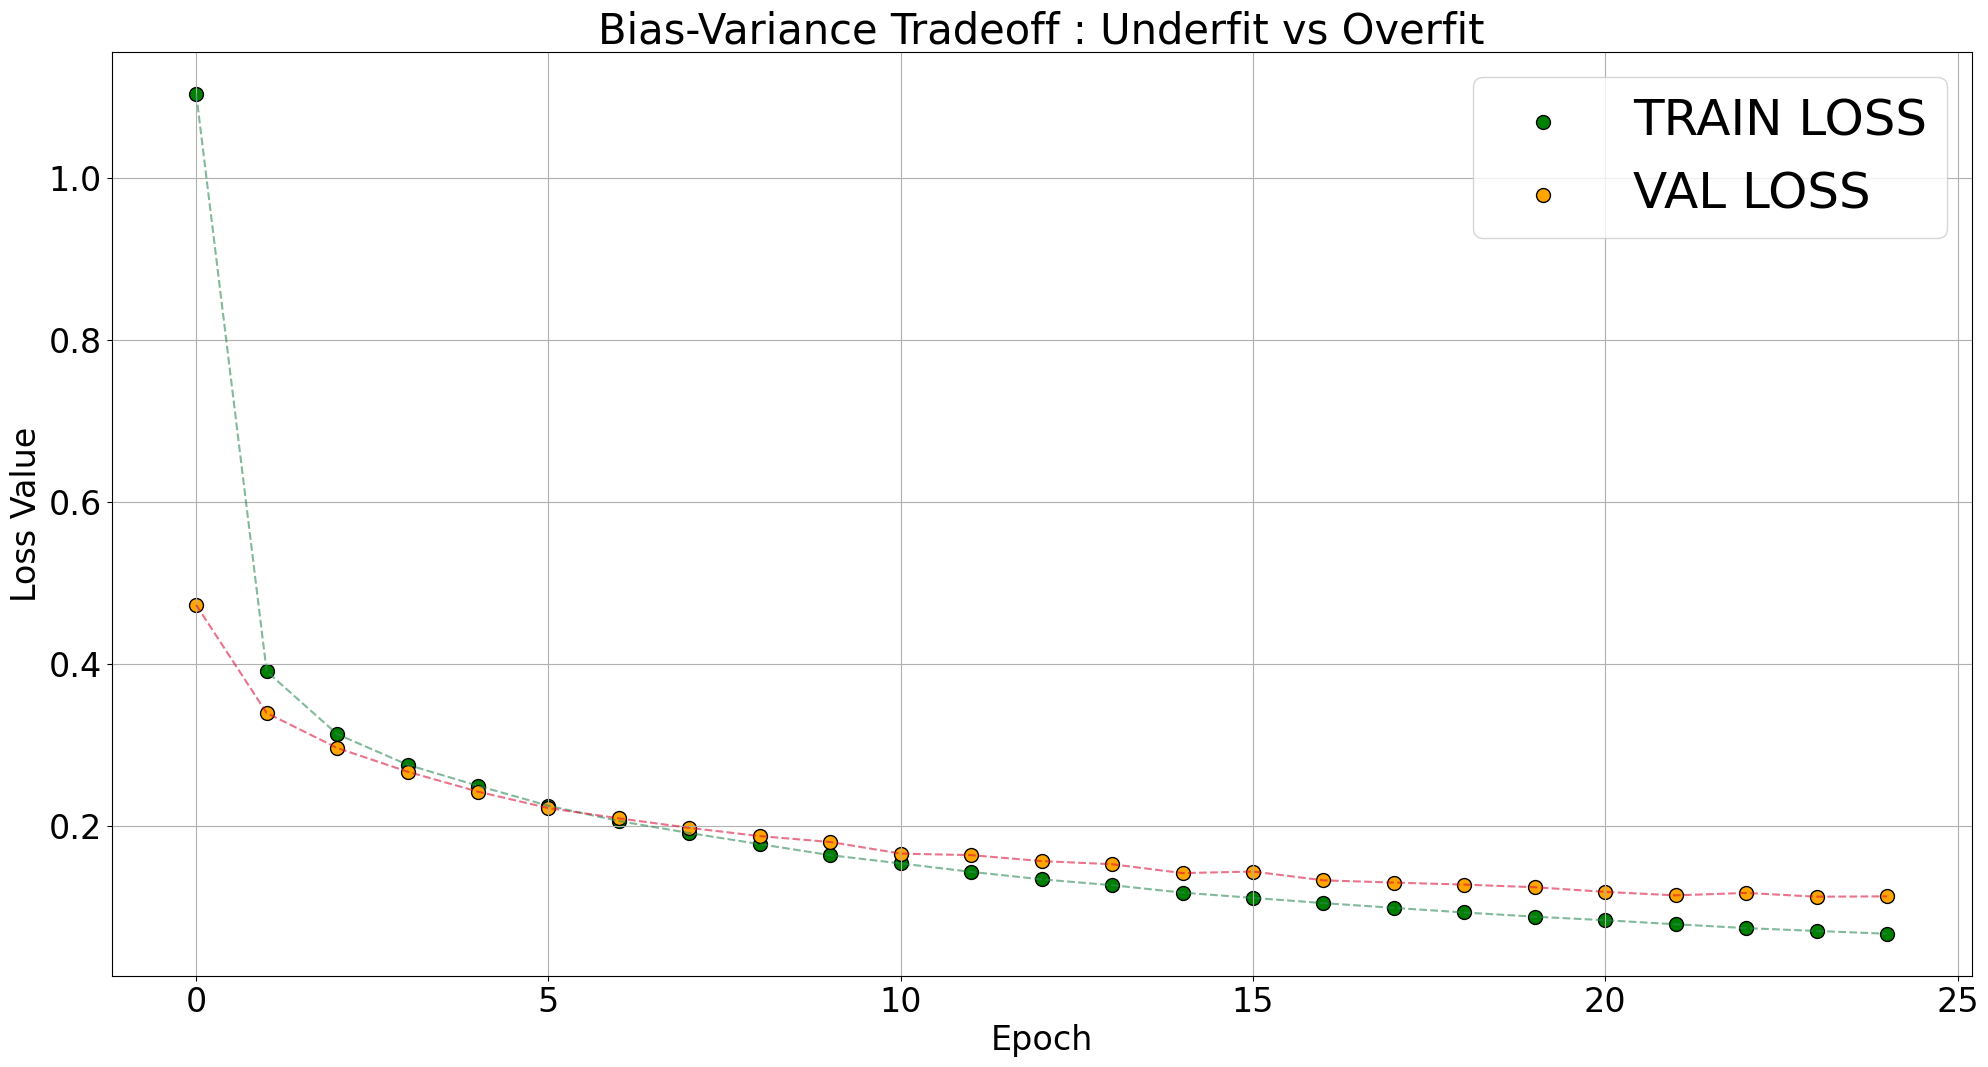

In [5]:
import matplotlib.pyplot as plt


loss1 = train_losses
loss2 = val_losses

# Create a new figure
plt.figure(figsize=(24, 12))

# Plot circles for loss1
plt.scatter(range(len(loss1)), loss1, color='green', edgecolor='black', s=100, label='TRAIN LOSS')

# Plot circles for loss2
plt.scatter(range(len(loss2)), loss2, color='orange', edgecolor='black', s=100, label='VAL LOSS')

# Connect the circles with lines
plt.plot(range(len(loss1)), loss1, color='seagreen', linestyle='--', alpha=0.6)
plt.plot(range(len(loss2)), loss2, color='crimson', linestyle='--', alpha=0.6)

# Add titles and labels
plt.title('Bias-Variance Tradeoff : Underfit vs Overfit', fontsize = 30)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Loss Value', fontsize=24)

# Add gridlines
plt.grid(True)

# Add a legend
plt.legend(fontsize=36)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)


# Show plot
plt.show()


### 4.3 Evaluate Results : METRIC ACCURACY

In [6]:
# Switch the model to evaluation mode
model.eval()

test_loss = 0.0
correct = 0
total = 0

# No need to calculate gradients during evaluation
with torch.no_grad():
    for inputs, labels in testloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Accumulate the test loss
        test_loss += loss.item() * inputs.size(0)
        
        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs, 1)
        
        # Count the number of correct predictions
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate the average test loss
test_loss /= len(testset)

# Calculate the accuracy
accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {accuracy:.2f}%')


Test Loss: 0.0992
Test Accuracy: 97.07%


__________________________________
# THANK YOU
________________________